In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
!cd "/content/drive/My Drive/hack/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
print(tf.__version__)
train_data =pd.read_excel('/content/drive/My Drive/hack/Test_dataset.xlsx','Put-Call_TS')
train_data=train_data.rename(columns={'Put-Call Ratio':'aug10','Unnamed: 2':'aug11','Unnamed: 3':'aug12','Unnamed: 4':'aug13','Unnamed: 5':'aug14','Unnamed: 6':'aug15'})
train_data=train_data.drop([0],axis=0)
print(train_data.head())
print(train_data.columns)

2.3.0
  Stock Index aug10  aug11    aug12     aug13     aug14     aug15
1      AC3235   0.8   0.66   0.7724  0.983224  0.901211  0.898368
2      AC3236  0.86  0.732  0.85448   1.08664   1.01704   1.02926
3      AC3237  0.93  0.816  0.95024    1.2073       NaN   1.18196
4      AC3238  1.09  1.008  1.16912   1.48309   1.46106     1.531
5      AC3239   NaN  1.104  1.27856   1.62099    1.6155   1.70552
Index(['Stock Index', 'aug10', 'aug11', 'aug12', 'aug13', 'aug14', 'aug15'], dtype='object')


In [2]:
#we dont std scale here since all the columns are of the same feature but will have different mean and std so will 16 aug have a different mean and std 
#so doesnt make sense to invese std scale using parameters of past days
#and the values are already very small(0,2)
train_data.fillna(-1,inplace=True)#fill in missing data 

all_cols=['Stock Index', 'aug10', 'aug11', 'aug12', 'aug13', 'aug14', 'aug15']
train_cols = ['aug10', 'aug11', 'aug12', 'aug13', 'aug14']
train_y_col = ['aug15']
test_cols =['aug11', 'aug12', 'aug13', 'aug14', 'aug15']
y=train_data[train_y_col]
train = train_data[train_cols]
test = train_data[test_cols]
test_indx = train_data['Stock Index']


print(train_data.columns)
print(train.head())
print(test.head())
print(y.head())
train = train.values
test = test.values
y=y.values
print(test_indx.head())

Index(['Stock Index', 'aug10', 'aug11', 'aug12', 'aug13', 'aug14', 'aug15'], dtype='object')
   aug10  aug11    aug12     aug13     aug14
1   0.80  0.660  0.77240  0.983224  0.901211
2   0.86  0.732  0.85448  1.086645  1.017042
3   0.93  0.816  0.95024  1.207302 -1.000000
4   1.09  1.008  1.16912  1.483091  1.461062
5  -1.00  1.104  1.27856  1.620986  1.615504
   aug11    aug12     aug13     aug14     aug15
1  0.660  0.77240  0.983224  0.901211  0.898368
2  0.732  0.85448  1.086645  1.017042  1.029258
3  0.816  0.95024  1.207302 -1.000000  1.181962
4  1.008  1.16912  1.483091  1.461062  1.531000
5  1.104  1.27856  1.620986  1.615504  1.705519
      aug15
1  0.898368
2  1.029258
3  1.181962
4  1.531000
5  1.705519
1    AC3235
2    AC3236
3    AC3237
4    AC3238
5    AC3239
Name: Stock Index, dtype: object


In [12]:
print(train.shape,y.shape,test.shape)
train = train.reshape(3331, 5,1)
test = test.reshape(3331, 5,1)
y = y.reshape(3331,1)
print(train.shape,y.shape,test.shape)
print(train[0],test[0])

(3331, 5, 1) (3331, 1, 1) (3331, 5, 1)
(3331, 5, 1) (3331, 1) (3331, 5, 1)
[[0.8       ]
 [0.66      ]
 [0.7724    ]
 [0.983224  ]
 [0.90121088]] [[0.66      ]
 [0.7724    ]
 [0.983224  ]
 [0.90121088]
 [0.89836829]]


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Lambda,Dropout
import numpy as np

data_dim = 1
timesteps = 5
nb_classes = 1

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(GRU(64, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))               
model.add(GRU(32, return_sequences=False))  # returns a sequence of vectors of dimension 32
#model.add(GRU(32))  # return a single vector of dimension 32
model.add(Dropout(0.5))              
model.add(Dense(1, activation='sigmoid'))
model.add(Lambda(lambda x: x*2))# to get output in (0,2)
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['mse'])
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train, y, train_size=0.8, random_state=1234)
print(X_train.shape,y_train.shape)
model.fit(X_train, y_train,
          batch_size=64,epochs=1000,
          validation_data=(X_validation, y_validation))

(2664, 5, 1) (2664, 1)
Train on 2664 samples, validate on 667 samples
Epoch 1/1000
2664/2664 [==============================] - 1s 462us/sample - loss: 0.4688 - mse: 0.4688 - val_loss: 0.4363 - val_mse: 0.4363
Epoch 2/1000
2664/2664 [==============================] - 0s 117us/sample - loss: 0.2934 - mse: 0.2934 - val_loss: 0.2762 - val_mse: 0.2762
Epoch 3/1000
2664/2664 [==============================] - 0s 124us/sample - loss: 0.2474 - mse: 0.2474 - val_loss: 0.2785 - val_mse: 0.2785
Epoch 4/1000
2664/2664 [==============================] - 0s 120us/sample - loss: 0.2459 - mse: 0.2459 - val_loss: 0.2742 - val_mse: 0.2742
Epoch 5/1000
2664/2664 [==============================] - 0s 119us/sample - loss: 0.2477 - mse: 0.2477 - val_loss: 0.2744 - val_mse: 0.2744
Epoch 6/1000
2664/2664 [==============================] - 0s 121us/sample - loss: 0.2478 - mse: 0.2478 - val_loss: 0.2746 - val_mse: 0.2746
Epoch 7/1000
2664/2664 [==============================] - 0s 120us/sample - loss: 0.2452 -

mse score on 20 percent data: 0.25156831762967097
mae score on 20percent data: 0.20812003110032248


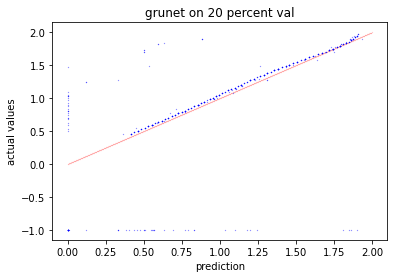

In [22]:
y_scores = model.predict(X_validation)
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error

score = mean_squared_error(y_validation, y_scores)
print("mse score on 20 percent data:",score)
score = mean_absolute_error(y_validation, y_scores)
print("mae score on 20percent data:",score)
# to check the fit on 5 percent validation we plot yscores vs yvalidation and see how much it follows y=x line

a=[]
for i in range(0,2000):
  a.append(i/1000)
plt.scatter(np.array(a),np.array(a), s=0.05, c='r', alpha=0.1)
plt.scatter(y_scores,y_validation, s=0.05, c='b', alpha=0.8)
plt.title("grunet on 20 percent val")
plt.xlabel('prediction')
plt.ylabel('actual values')
plt.savefig('/content/drive/My Drive/hack/data analysis/'+"gru_regression_test_20percent"+'.jpg',)
plt.show()


NOW to train on 95 percent data since the model looks good when trained on 80 percent data

(2941, 5, 1) (2941, 1)
(151, 5, 1) (151, 1)
Train on 2941 samples, validate on 151 samples
Epoch 1/200
2941/2941 [==============================] - 2s 660us/sample - loss: 0.1260 - mse: 0.1260 - val_loss: 0.0611 - val_mse: 0.0611
Epoch 2/200
2941/2941 [==============================] - 0s 139us/sample - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 3/200
2941/2941 [==============================] - 0s 136us/sample - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 4/200
2941/2941 [==============================] - 0s 140us/sample - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/200
2941/2941 [==============================] - 0s 138us/sample - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/200
2941/2941 [==============================] - 0s 136us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/200
2941/2941 [==============================] - 0s 137us/sample - 

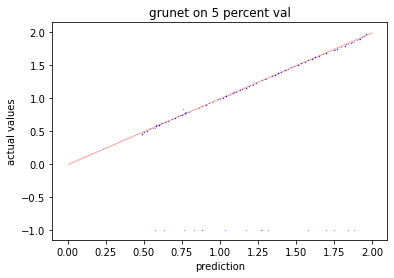

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Lambda
import numpy as np

data_dim = 1
timesteps = 5
nb_classes = 1
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(GRU(64, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))               
model.add(GRU(64, return_sequences=False))  # returns a sequence of vectors of dimension 32
#model.add(GRU(32))  # return a single vector of dimension 32
model.add(Dropout(0.5))              
model.add(Dense(1, activation='sigmoid'))
model.add(Lambda(lambda x: x*2))# to get output in (0,2)
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['mse'])


from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(train, y, train_size=0.95, random_state=1234)
#remove rows with misssing values in target y
new_x_train =[]
new_y_train = []
for i in range(y_train.shape[0]):
  if y_train[i]!= -1:
    new_y_train.append(y_train[i])
    new_x_train.append(X_train[i])
new_y_train = np.array(new_y_train)

new_x_train = np.array(new_x_train)

new_x_validation =[]
new_y_validation = []
for i in range(y_validation.shape[0]):
  if y_validation[i]!= -1:
    new_y_validation.append(y_validation[i])
    new_x_validation.append(X_validation[i])
new_y_validation = np.array(new_y_validation)

new_x_validation = np.array(new_x_validation)
print(new_x_train.shape,new_y_train.shape)
print(new_x_validation.shape,new_y_validation.shape)
model.fit(new_x_train, new_y_train,
          batch_size=64,epochs=200,
          validation_data=(new_x_validation, new_y_validation))
model.save('/content/drive/My Drive/hack/models/gru.h5')
y_scores = model.predict(X_validation)
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error

score = mean_squared_error(y_validation, y_scores)
print("mse score on 5 percent data:",score)
score = mean_absolute_error(y_validation, y_scores)
print("mae score on 5 percent data:",score)
# to check the fit on 5 percent validation we plot yscores vs yvalidation and see how much it follows y=x line

a=[]
for i in range(0,2000):
  a.append(i/1000)
plt.scatter(np.array(a),np.array(a), s=0.05, c='r', alpha=0.1)
plt.scatter(y_scores,y_validation, s=0.05, c='b', alpha=0.8)
plt.title("grunet on 5 percent val")
plt.xlabel('prediction')
plt.ylabel('actual values')
plt.savefig('/content/drive/My Drive/hack/data analysis/'+"gru_regression_test_final"+'.jpg',)
plt.show()

NOW TO PREDICT FOR 16 AUG

In [30]:

y_scores = model.predict(test)

In [31]:
sub = pd.DataFrame()
sub['Stock Index']=test_indx
sub['Put-Call Ratio'] = y_scores

In [35]:
print(sub.head())
sub.to_csv('/content/drive/My Drive/hack/task2_outputs/gru_16AUG.csv',index=False)

  Stock Index  Put-Call Ratio
1      AC3235        0.951753
2      AC3236        1.112391
3      AC3237        1.251455
4      AC3238        1.696231
5      AC3239        1.906235
